In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_csv_file = 'mallet_data_oldp_supercap.csv'  # Replace with your input CSV file name
raw_file = pd.read_csv(input_csv_file)

# Extract pulley radius from the first row
PULLEY_RADIUS = raw_file.loc[0, "x"]
print("PULLEY_RADIUS =", "{:.6e}".format(PULLEY_RADIUS))
with open('pulley_radius.txt', "w") as file:
        file.write("{:.6e}".format(PULLEY_RADIUS))

# Remove first row
raw_file = raw_file.iloc[1:raw_file.shape[0]].reset_index(drop=True)  

PULLEY_RADIUS = 3.572354e-02


In [47]:
file_end = np.where((abs(raw_file['x']) < 1e-16) & (abs(raw_file['y']) < 1e-16))[0][0]
raw_file = raw_file.iloc[0:file_end]

#### Smooth outliers in raw file

Calculate discrepancies

In [18]:
outlier_csv = raw_file.copy()
coords = outlier_csv[['x','y']].to_numpy()

# Neighbor arrays
prev_coords = np.roll(coords, 1, axis=0)
next_coords = np.roll(coords, -1, axis=0)

# Distances
dist_prev = np.linalg.norm(coords - prev_coords, axis=1)
dist_next = np.linalg.norm(coords - next_coords, axis=1)

# Discrepancy measure
discrepancy = dist_prev*dist_next

Sort based on discrepancies

In [19]:
# Store it if you want to inspect
outlier_csv['discrepancy'] = discrepancy
outliers_sorted = outlier_csv.sort_values('discrepancy', ascending=False)

top_outliers = outliers_sorted.iloc[0:3,:]
print(top_outliers)

              x         y  Expected_x  Expected_y  Left_PWM  Right_PWM  \
27402  0.622509  0.400601    0.628574    0.400334 -0.567574   0.250938   
6521   0.677480  0.418416    0.666570    0.417844 -0.578048   0.360881   
5292   0.627850  0.213218    0.612094    0.213370  0.378707  -0.345473   

             dt  discrepancy  
27402  0.976577     0.000370  
6521   1.266488     0.000023  
5292   1.266488     0.000022  


In [20]:
# for index in top_outliers.index:
#     if index == 0 or index == len(coords) - 1:
#         continue  # Skip first and last rows
#     print(raw_file.iloc[index-1:index+2,:])
#     print("----------------------------")

Replace outliers

In [21]:
# --- Vectorized replacement ---
# Note: 
threshold = 1e-4 # <-- choose your threshold here

mask = discrepancy > threshold

# Compute neighbor averages
avg_neighbors = (prev_coords + next_coords) / 2

# Replace only where mask is True (excluding first/last index)
valid_mask = mask & (np.arange(len(coords)) > 0) & (np.arange(len(coords)) < len(coords)-1)

coords[valid_mask] = avg_neighbors[valid_mask]

# Put back into df
raw_file[['x','y']] = coords

Function to ignore low voltage segments

In [22]:
def find_low_pwm(voltage_series):
    # Parameters for near-0 detection
    window_len = 50  # number of samples in each window
    v_abs_thresh = 0.1  # max absolute value of Vy to be considered "hovering"
    v_std_thresh = 0.04  # max std of Vy in window

    hover_segments = []
    segments = 0
    start = None

    for i in range(len(voltage_series) - window_len + 1):
        window = voltage_series.iloc[i:i+window_len]
        if (np.max(np.abs(window)) < v_abs_thresh) and (np.std(window) < v_std_thresh):
            if start is None:
                start = i
                if hover_segments and i < hover_segments[segments-1][1]+2*window_len:
                        start = hover_segments[segments-1][1]+1
        else:
            if start is not None:
                hover_segments.append((start, i+window_len))
                segments += 1
                start = None

    # Handle case where segment goes to the end
    if start is not None:
        hover_segments.append((start, len(voltage_series)-1))

    excluded_indices = set()
    for seg in hover_segments:
        excluded_indices.update(range(seg[0], seg[1] + 1))

    return excluded_indices

In [23]:
Vx = (raw_file['Left_PWM'] - raw_file['Right_PWM'])
Vy = (-raw_file['Left_PWM'] - raw_file['Right_PWM'])

Cut out low voltages from fit data

In [24]:
low_pwm = sorted(list(find_low_pwm(Vx) | find_low_pwm(Vy)))

In [25]:
trimmed_file = raw_file.drop(index=low_pwm).reset_index(drop=False)
split_files = []
num_splits = 0
reset = 0
j = 0
for i in range(len(trimmed_file)-1):
    if reset:
        j = 0
        reset = 0
    elif j < len(trimmed_file)-2:
        j += 1
    if trimmed_file.loc[j+1, 'index'] - trimmed_file.loc[j, 'index'] > 1:
        split_files.append(trimmed_file.iloc[:j+1,:].reset_index(drop=True))
        trimmed_file = trimmed_file.iloc[j+1:,:].reset_index(drop=True)
        reset = 1
        num_splits += 1
split_files.append(trimmed_file.reset_index(drop=True))
num_splits += 1

print(f"Number of split files created: {num_splits}")

Number of split files created: 11


Find valid file splitting points

In [26]:
import scipy.stats as stats

def filter_and_analyze_mallet_data(df, window_size=27, r_squared_threshold=0.95, max_residual=0.001):
    """
    Filter air hockey mallet data to remove collision points and calculate velocities.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns ['x', 'y', 'dt']
    window_size : int
        Number of points to use for local line fitting (should be odd)
    r_squared_threshold : float
        Minimum RÂ² value for a point to be considered on a straight line
    max_residual : float
        Maximum acceptable residual (in meters) for outlier detection
    
    Returns:
    --------
    pandas.DataFrame with columns ['x', 'y', 't', 'vx', 'vy']
        Filtered data with cumulative time and velocity components
    """
    # Calculate cumulative time
    t = np.cumsum(df['dt'].values)
    t = np.insert(t, 0, 0)[:-1]  # Shift so first point is at t=0
    
    # Create extended dataframe with time
    data = pd.DataFrame({
        'x': df['x'].values,
        'y': df['y'].values,
        't': t
    })
    
    n = len(data)
    half_window = window_size // 2

    idxs = []
    
    for i in range(half_window, n-half_window):
        if data['x'][i] < 0.02 or data['x'][i] > 1.993 - 0.02 or data['y'][i] < 0.02 or data['y'][i] > 0.992-0.02:
            continue
        # Define window around point i
        start_idx = max(0, i - half_window)
        end_idx = min(n, i + half_window + 1)
        
        if i-start_idx in low_pwm or i+end_idx in low_pwm or i in low_pwm:
            continue
        
        # Get window data
        window_x = data['x'].iloc[start_idx:end_idx].values
        window_y = data['y'].iloc[start_idx:end_idx].values
        window_t = data['t'].iloc[start_idx:end_idx].values
        
        # Skip if window too small
        if len(window_x) < 3:
            continue
        
        # ===== STEP 1: Screen points by fitting a line through (x,y) spatial coordinates =====
        # Fit line y = mx + b through the (x,y) points
        # Handle vertical lines by checking variance
        var_x = np.var(window_x)
        var_y = np.var(window_y)
        
        try:
            if var_x > var_y:
                # Fit y = mx + b (more horizontal line)
                slope, intercept, r, _, _ = stats.linregress(window_x, window_y)
                # Calculate perpendicular distance from each point to the line
                # Line: mx - y + b = 0, distance = |mx - y + b| / sqrt(m^2 + 1)
                residuals = np.abs(slope * window_x - window_y + intercept) / np.sqrt(slope**2 + 1)
                r_squared = r ** 2
            else:
                # Fit x = my + b (more vertical line)
                slope, intercept, r, _, _ = stats.linregress(window_y, window_x)
                # Line: my - x + b = 0, distance = |my - x + b| / sqrt(m^2 + 1)
                residuals = np.abs(slope * window_y - window_x + intercept) / np.sqrt(slope**2 + 1)
                r_squared = r ** 2
        except Exception as e:
            continue
        
        # Check if spatial line fits well with no outliers
        good_fit = r_squared >= r_squared_threshold
        no_outliers = np.max(residuals) <= max_residual
        
        if good_fit and no_outliers:
            idxs.append(i)
    
    return idxs

mask = []
for i in range(num_splits):
    idxs = filter_and_analyze_mallet_data(split_files[i])
    mask_i = np.zeros(len(split_files[i]), dtype=bool)
    mask_i[idxs] = True
    mask.append(mask_i)

# idxs = filter_and_analyze_mallet_data(raw_file)
# mask = np.zeros(len(raw_file), dtype=bool)
# mask[idxs] = True

# fig = plt.figure(figsize=(18, 12))
# plt.scatter(raw_file['x'][mask], raw_file['y'][mask], s=1, label='Filtered Data', alpha=0.8)
# plt.scatter(raw_file['x'][~mask], raw_file['y'][~mask], s=1, label='Unfiltered Data', alpha=0.8)
# plt.legend()
# plt.show()

Linear regression

In [12]:
window_size = [27, 27]   # must be odd for regression center
half_window = [w // 2 for w in window_size]
chunk_size = 250  # Number of rows per output file

In [13]:
# Add empty columns first
raw_file["X_Velocity_m_s_"] = np.nan
raw_file["Y_Velocity_m_s_"] = np.nan
raw_file["X_Accel_m_s2_"] = np.nan
raw_file["Y_Accel_m_s2_"] = np.nan

# --- Choose a segment  ---

split_idxs = []

file = 0

for split_file in split_files:
    i = half_window[0]
    while True:
        split_idxs.append(i)
        for w in range(len(window_size)):
            # Select segment centered at i*1000
            start = max(0, i - half_window[w])
            end   = min(len(split_file), i + half_window[w])
            center_idx = (start + (end - start) // 2) * (i > 0)

            segment = split_file.iloc[start:end+1].reset_index(drop=True)

            # --- Extract time array ---
            dt = segment["dt"].to_numpy()
            # --- Cumulative time (needed for regression) ---
            t = (np.cumsum(dt)-dt[0]) / 1000.0 # convert to seconds

            
            if w == 0:
                # --- Extract x array ---
                x = segment["x"].to_numpy()
                # ======================
                # 1) Linear regression method
                # ======================
                # Fit x(t) quadratically: ax*t^2 + bx + c
                coef_x, residual_x, _, _, _ = np.polyfit(t, x, 2, full=True)
                ax, vx = 2*coef_x[0], coef_x[1]     # acceleration, initial velocity
                vel_x = ax * t + vx
                accel_x = np.full(len(vel_x), ax)
                
                split_file.loc[start:end, "X_Velocity_m_s_"] = vel_x
                split_file.loc[start:end, "X_Accel_m_s2_"] = accel_x
                split_file.loc[center_idx, "x"] = ax / 2 * t[center_idx - start]**2 + vx * t[center_idx - start] + coef_x[2]
            elif w == 1:
                # --- Extract y array ---
                y = segment["y"].to_numpy()
                # ======================
                # Fit y(t) quadratically: ay*t^2 + by + c
                coef_y, residual_y, _, _, _ = np.polyfit(t, y, 2, full=True)
                ay, vy = 2*coef_y[0], coef_y[1]     # acceleration, initial velocity
                vel_y = ay * t + vy
                accel_y = np.full(len(vel_y), ay)
                split_file.loc[start:end, "Y_Velocity_m_s_"] = vel_y
                split_file.loc[start:end, "Y_Accel_m_s2_"] = accel_y
                split_file.loc[center_idx, "y"] = ay / 2 * t[center_idx - start]**2 + vy * t[center_idx - start] + coef_y[2]

        counter = 0
        while counter < chunk_size or not mask[file][i]:
            i += 1
            counter += 1
            if i >= len(split_file) - half_window[0]:
                break

        if i >= len(split_file) - half_window[0]:
            file += 1
            break


Split CSV into chunks

In [ ]:
# for chunk in pd.read_csv(input_csv_file, chunksize=chunk_size):
#     output_filename = f'feedforward_data_12V_{batch_number}.csv'
#     chunk.to_csv(output_filename, index=False)  # index=False prevents writing the DataFrame index
#     batch_number += 1

file = 0
created = len(split_idxs)
for i in range(len(split_idxs)):
    if i < len(split_idxs)-1:
        if split_idxs[i+1] <= split_idxs[i]:
            file += 1
            created -= 1
            continue
    chunk = split_files[file].iloc[split_idxs[i]:split_idxs[i+1] if i+1 < len(split_idxs) else len(raw_file)]
    output_filename = f'feedforward_data_12V_{i+1-file}.csv'
    chunk.to_csv(output_filename, index=False)
    
# for i in range(1):
#     output_filename = f'feedforward_data_12V_{i+1}.csv'
#     raw_file.to_csv(output_filename, index=False)

print(f"CSV file '{input_csv_file}' split into {created} files.")

CSV file 'mallet_data_NN_paths.csv' split into 158 files.


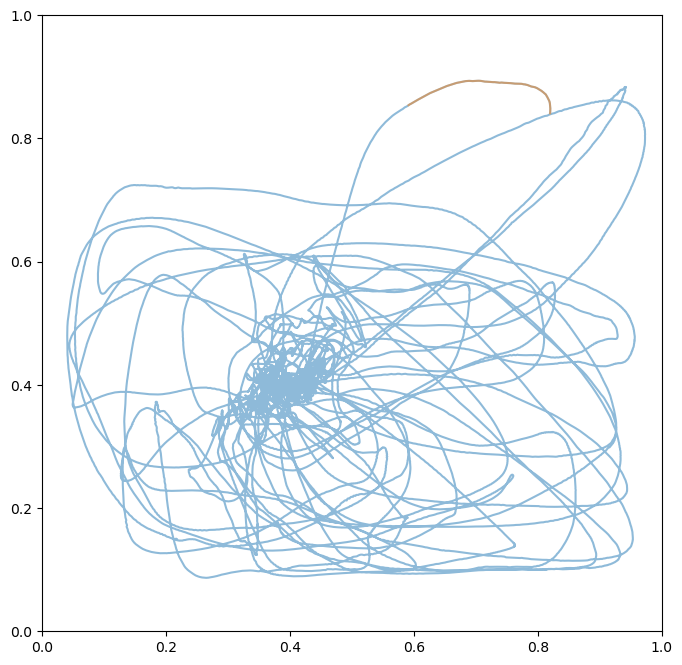

In [147]:
# plt.figure(figsize=(12, 6))
# plt.xlim(0, 2)
# plt.ylim(0, 1)
plt.figure(figsize=(8, 8))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(raw_file['x'], raw_file['y'], label='Position', alpha=0.5)
path_chunk = pd.read_csv('feedforward_data_12V_171.csv')
plt.plot(path_chunk['x'], path_chunk['y'], label='Chunk Position', alpha=0.5)
plt.show()

In [ ]:
fig = plt.figure(figsize=(20, 8))
plt.plot(np.cumsum(raw_file['dt'][0:1000])/1000.0, raw_file['Left_PWM'][0:1000], label='V1')
plt.plot(np.cumsum(raw_file['dt'][0:1000])/1000.0, raw_file['Right_PWM'][0:1000], label='V2')

KeyError: 'Left_PWM'

<Figure size 2000x800 with 0 Axes>

In [111]:
Vx, Vy = [[1, -1], [-1, -1]] @ np.array([raw_file['Left_PWM'], raw_file['Right_PWM']])

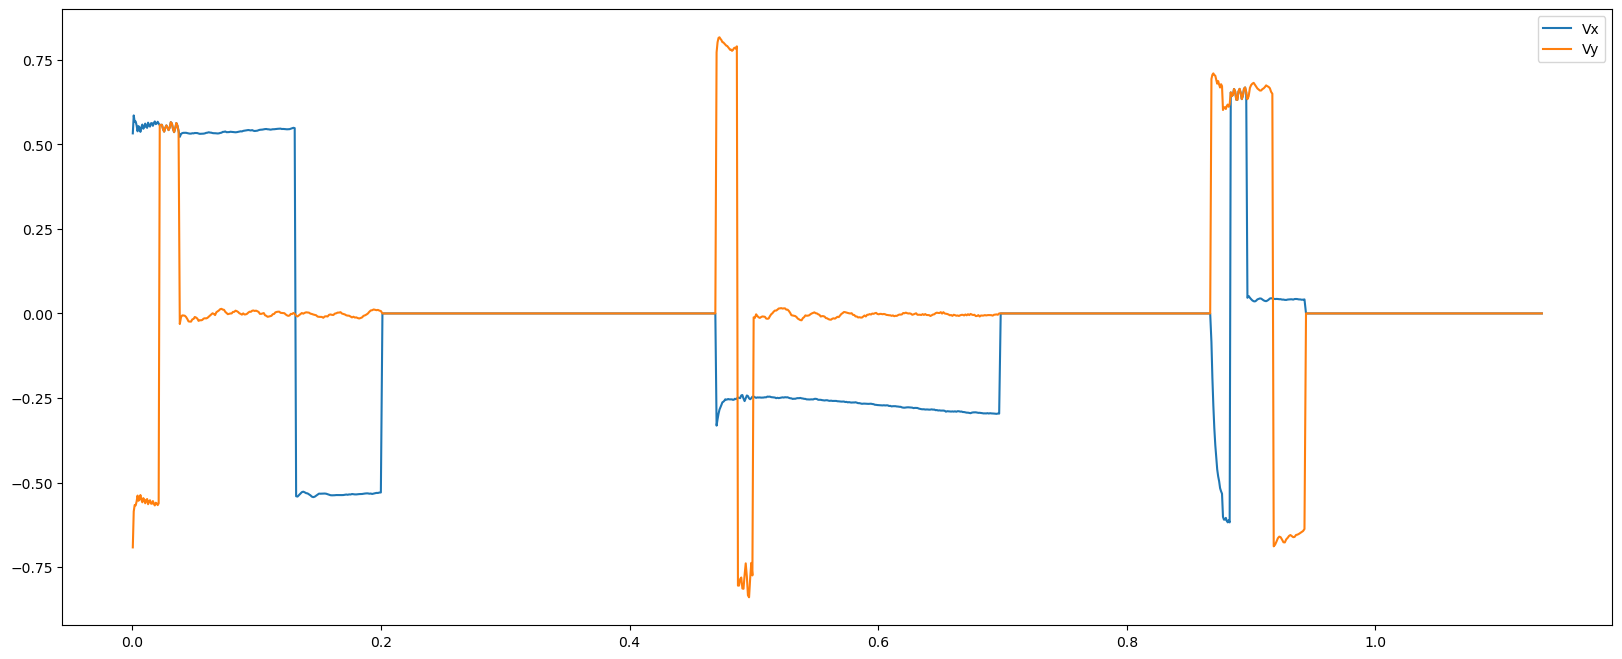

In [112]:
fig = plt.figure(figsize=(20, 8))
plt.plot(np.cumsum(raw_file['dt'][0:1000])/1000.0, Vx[0:1000], label='Vx')
plt.plot(np.cumsum(raw_file['dt'][0:1000])/1000.0, Vy[0:1000], label='Vy')
plt.legend()
plt.show()

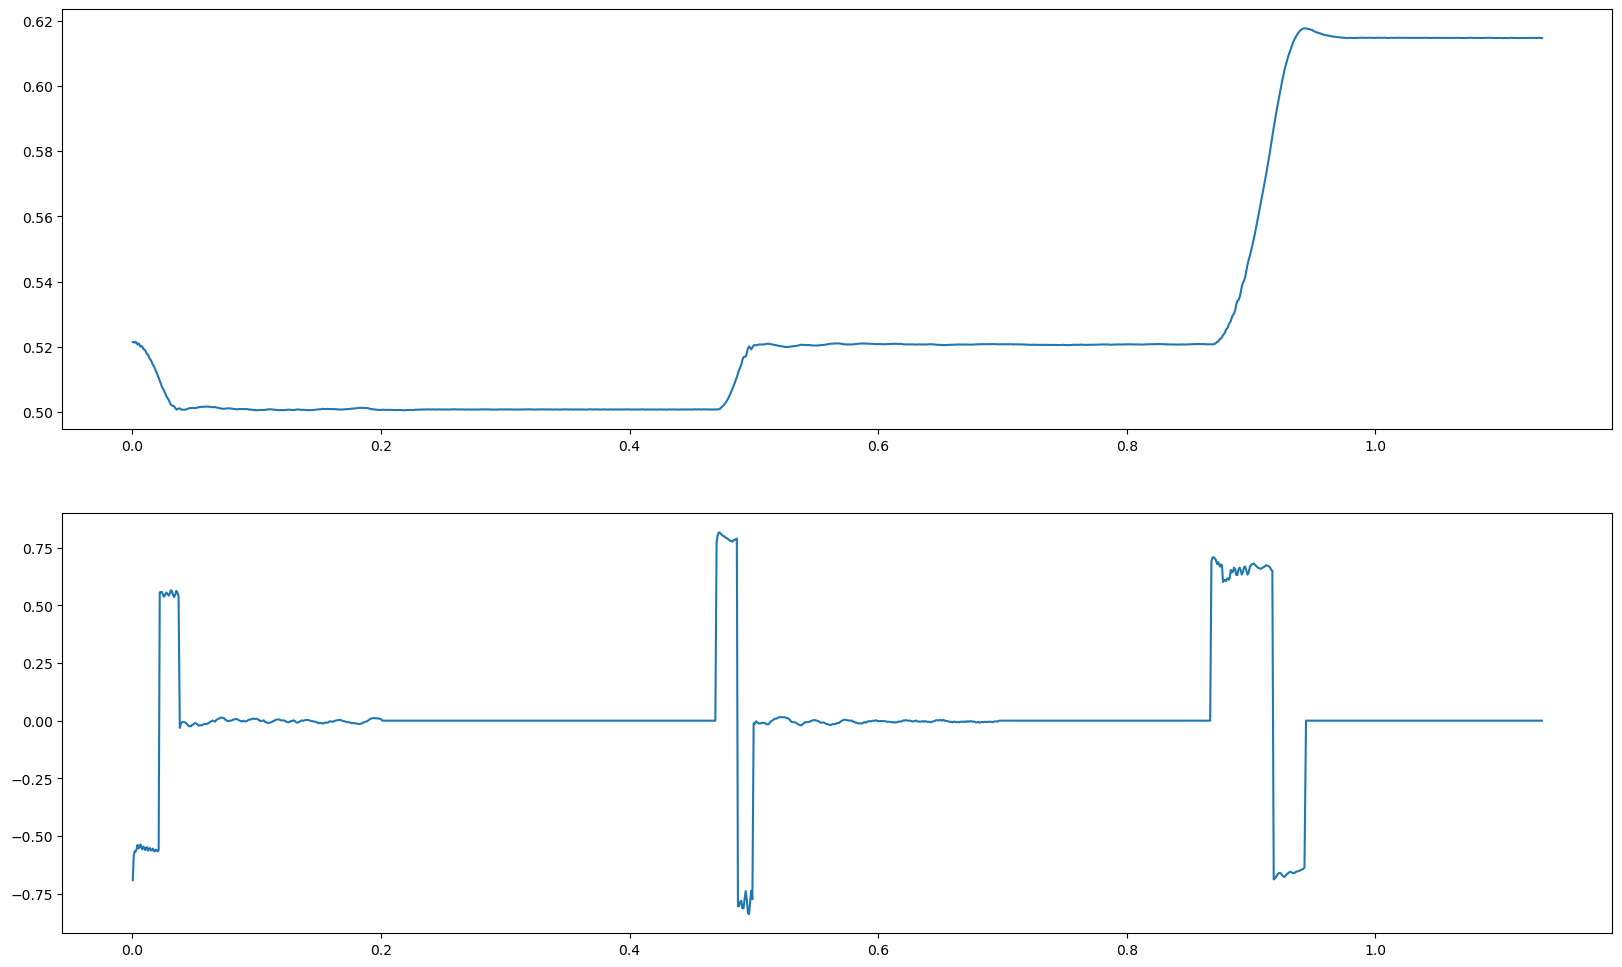

In [113]:
fig = plt.figure(figsize=(20, 12))
subplot1 = fig.add_subplot(2, 1, 1)
plt.plot(np.cumsum(raw_file['dt'][0:1000])/1000.0, raw_file['y'][0:1000], label='X')
subplot2 = fig.add_subplot(2, 1, 2)
plt.plot(np.cumsum(raw_file['dt'][0:1000])/1000.0, Vy[0:1000], label='Vx')
plt.show()

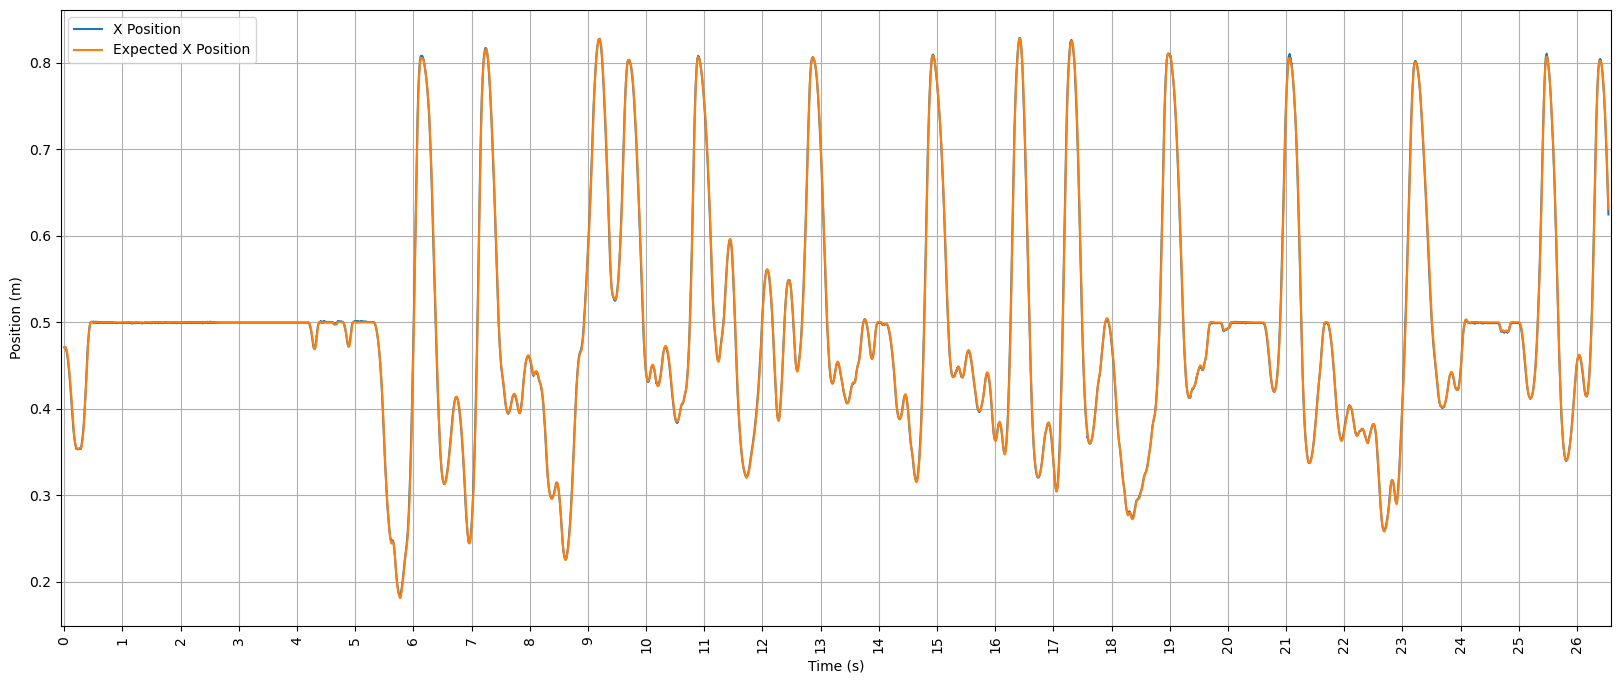

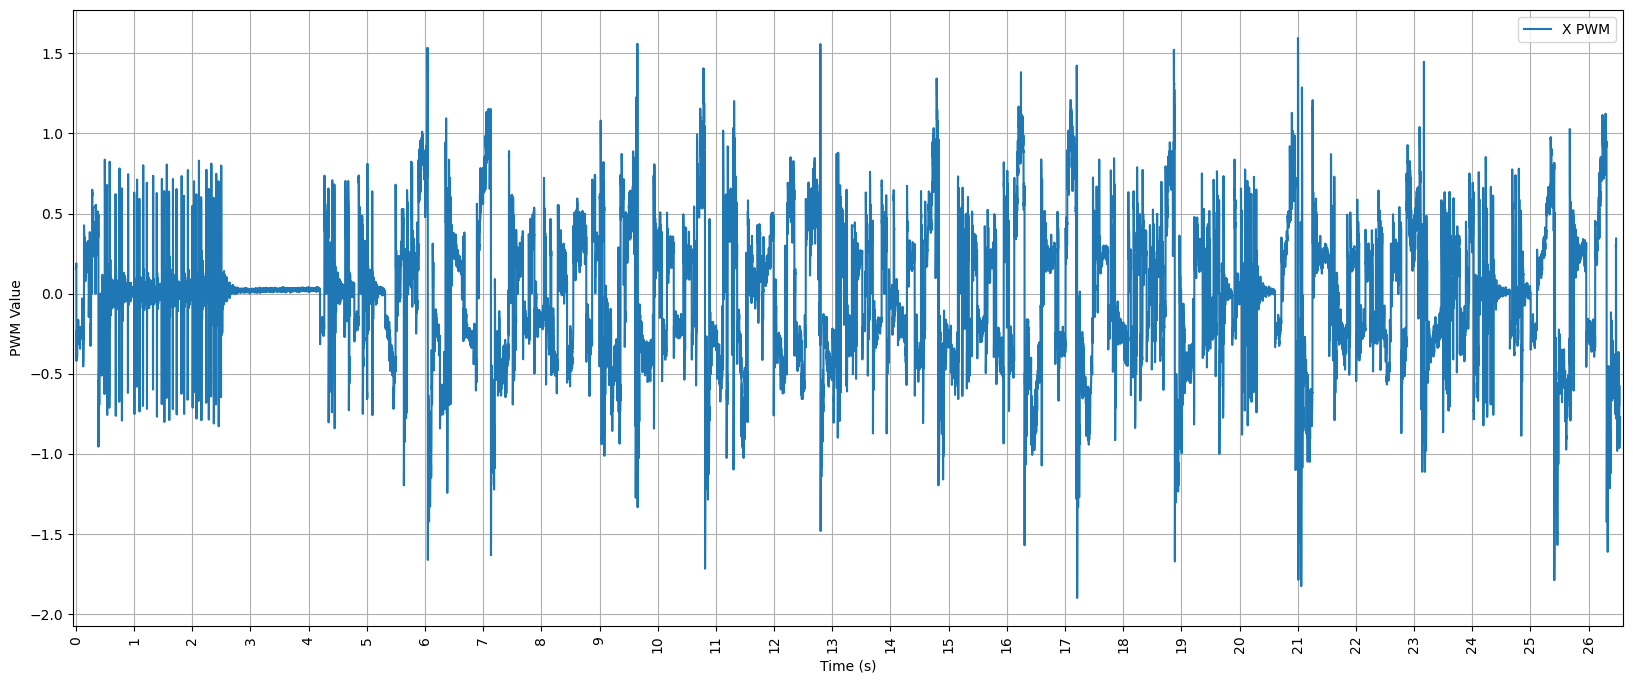

In [27]:
time = np.cumsum(raw_file['dt'])/1000.0-raw_file['dt'][0]/1000.0
start_idx = np.where(time >= 0)[0][0]
end_idx = len(raw_file) -1#np.where(time >= 4.5)[0][0]
fig = plt.figure(figsize=(20, 8))
plt.plot(time[start_idx:end_idx], raw_file['x'][start_idx:end_idx], label='X Position')
plt.plot(time[start_idx:end_idx], raw_file['Expected_x'][start_idx:end_idx], label='Expected X Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.xticks(np.arange(time[start_idx], time[end_idx], 1), rotation=90)
plt.xlim(time[start_idx]-0.05, time[end_idx]+0.05)
plt.grid()
plt.legend()
plt.show()
fig2 = plt.figure(figsize=(20, 8))
plt.plot(time[start_idx:end_idx], Vx[start_idx:end_idx], label='X PWM')
plt.xlabel('Time (s)')
plt.ylabel('PWM Value')
plt.xticks(np.arange(time[start_idx], time[end_idx], 1), rotation=90)
plt.xlim(time[start_idx]-0.05, time[end_idx]+0.05)
plt.grid()
plt.legend()
plt.show()

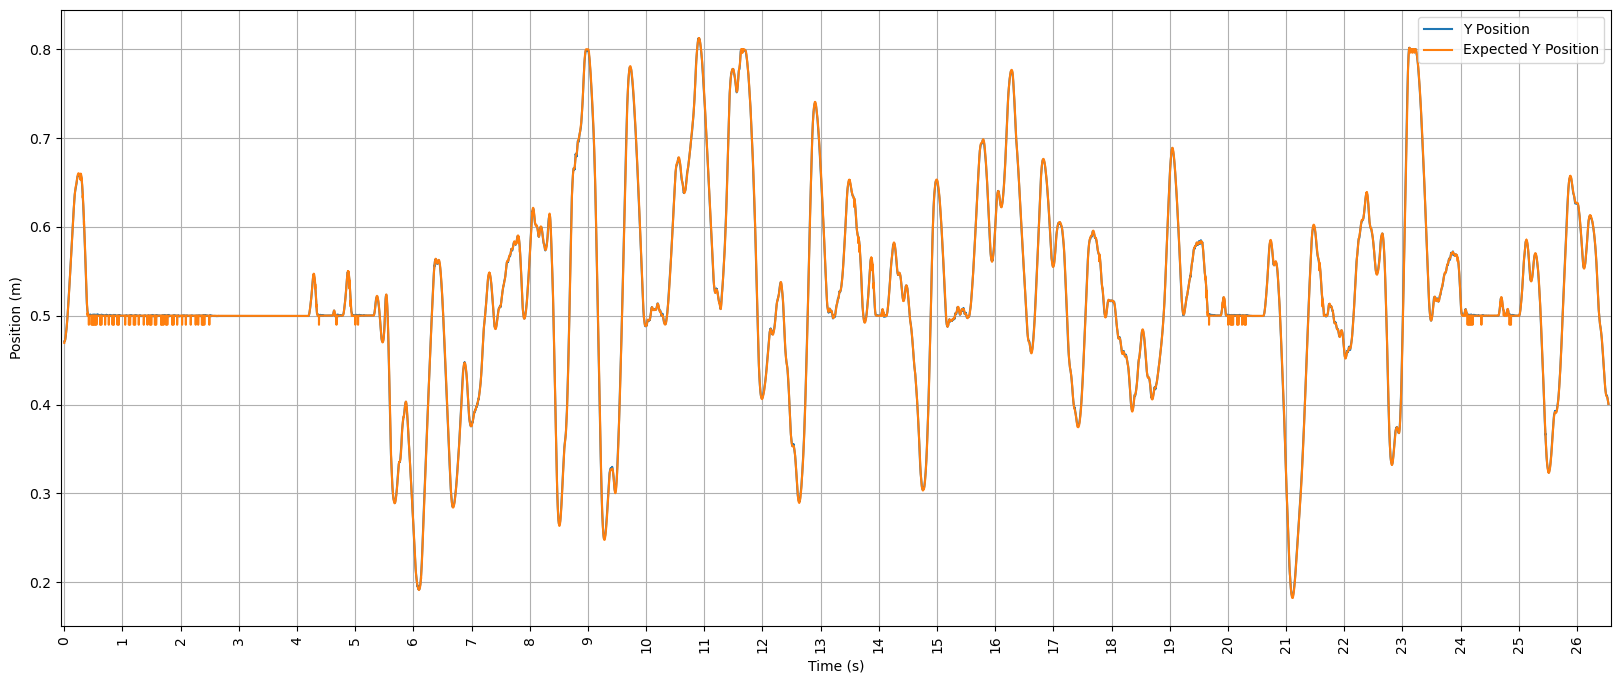

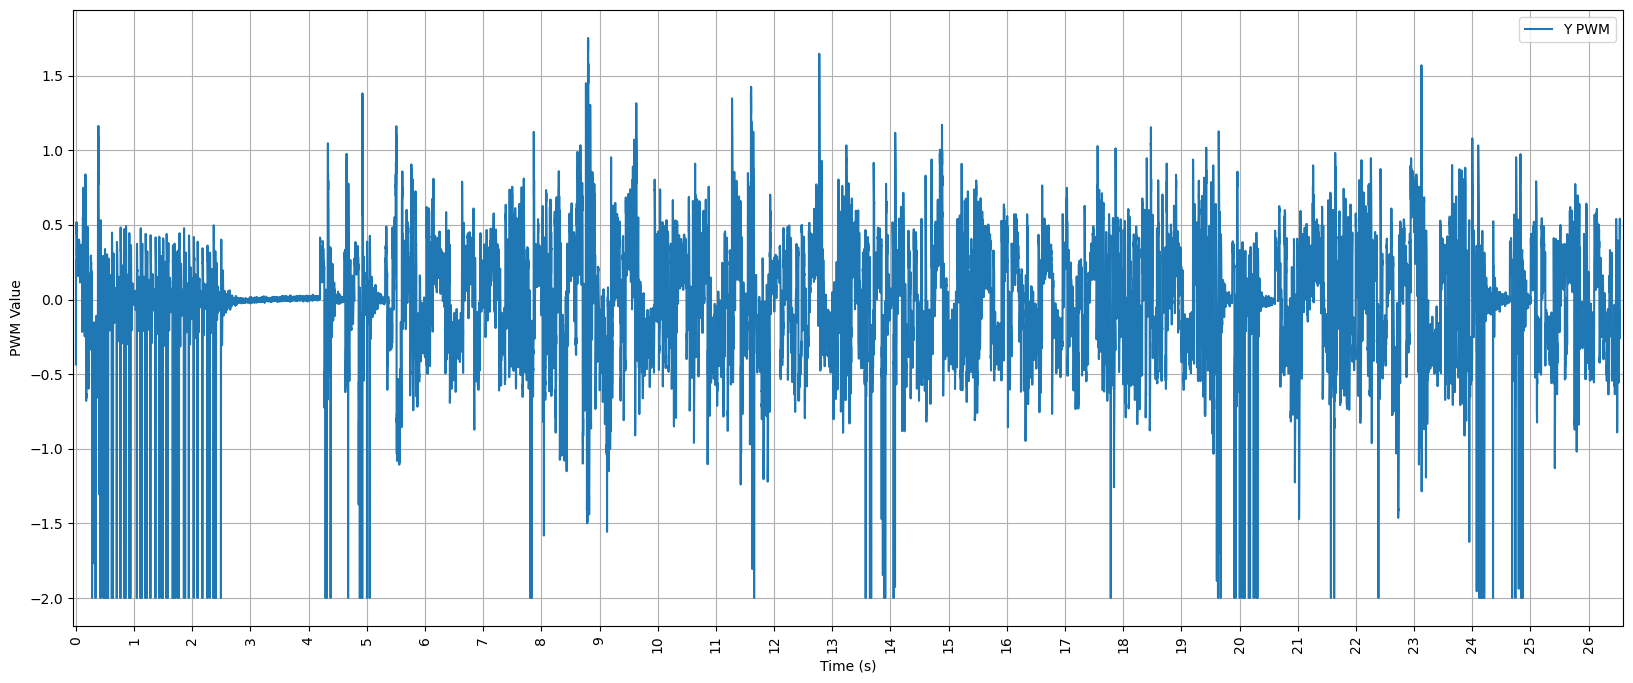

In [28]:
time = np.cumsum(raw_file['dt'])/1000.0-raw_file['dt'][0]/1000.0
start_idx = np.where(time >= 0)[0][0]
end_idx = len(raw_file) -1#np.where(time >= 5)[0][0]
fig = plt.figure(figsize=(20, 8))
plt.plot(time[start_idx:end_idx], raw_file['y'][start_idx:end_idx], label='Y Position')
plt.plot(time[start_idx:end_idx], raw_file['Expected_y'][start_idx:end_idx], label='Expected Y Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.xticks(np.arange(time[start_idx], time[end_idx], 1), rotation=90)
plt.xlim(time[start_idx]-0.05, time[end_idx]+0.05)
plt.grid()
plt.legend()
plt.show()
fig2 = plt.figure(figsize=(20, 8))
plt.plot(time[start_idx:end_idx], Vy[start_idx:end_idx], label='Y PWM')
plt.xlabel('Time (s)')
plt.ylabel('PWM Value')
plt.xticks(np.arange(time[start_idx], time[end_idx], 1), rotation=90)
plt.xlim(time[start_idx]-0.05, time[end_idx]+0.05)
plt.grid()
plt.legend()
plt.show()

In [17]:
sim_file = pd.read_csv('feedforward_sim_data_NN_NoLow.csv')

In [18]:
# low_vx = sorted(list(find_low_pwm(Vx)))

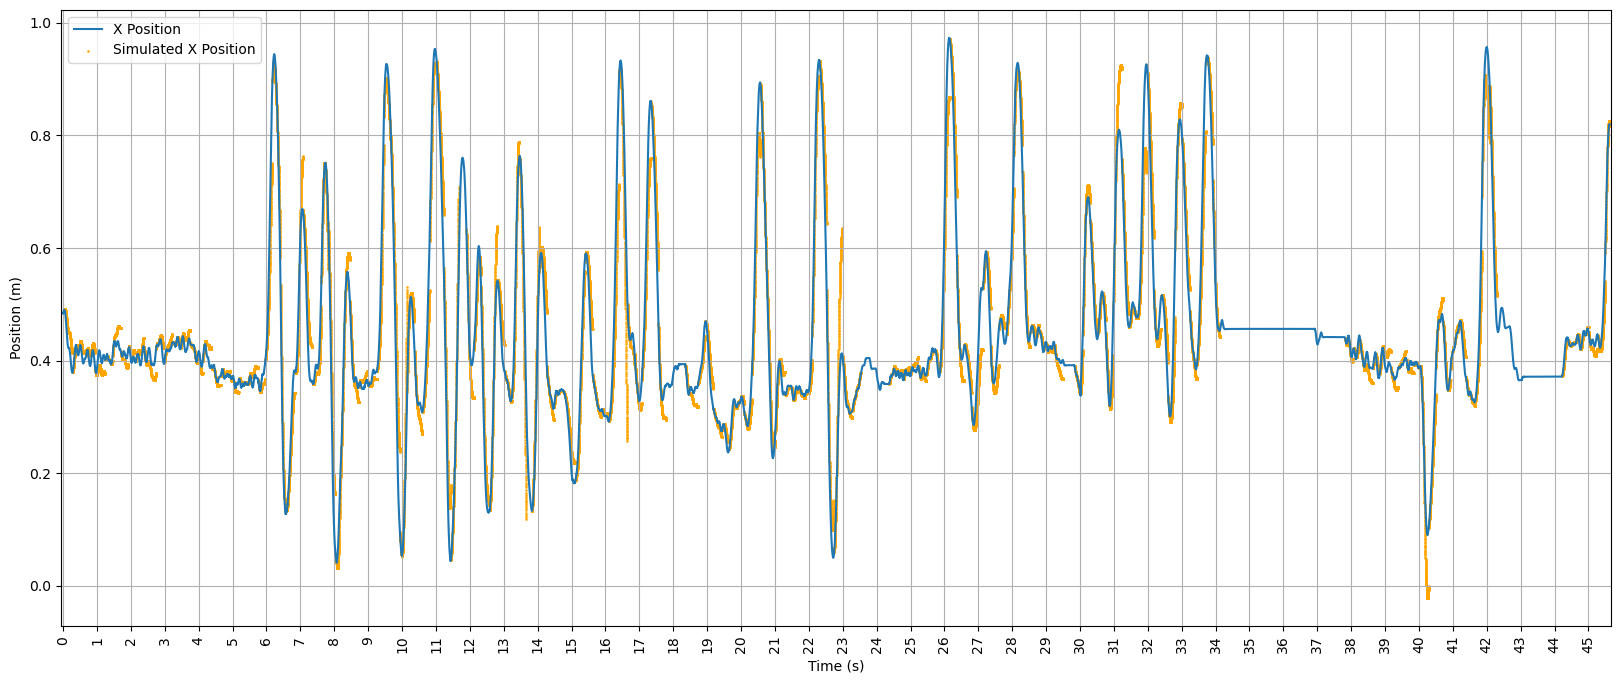

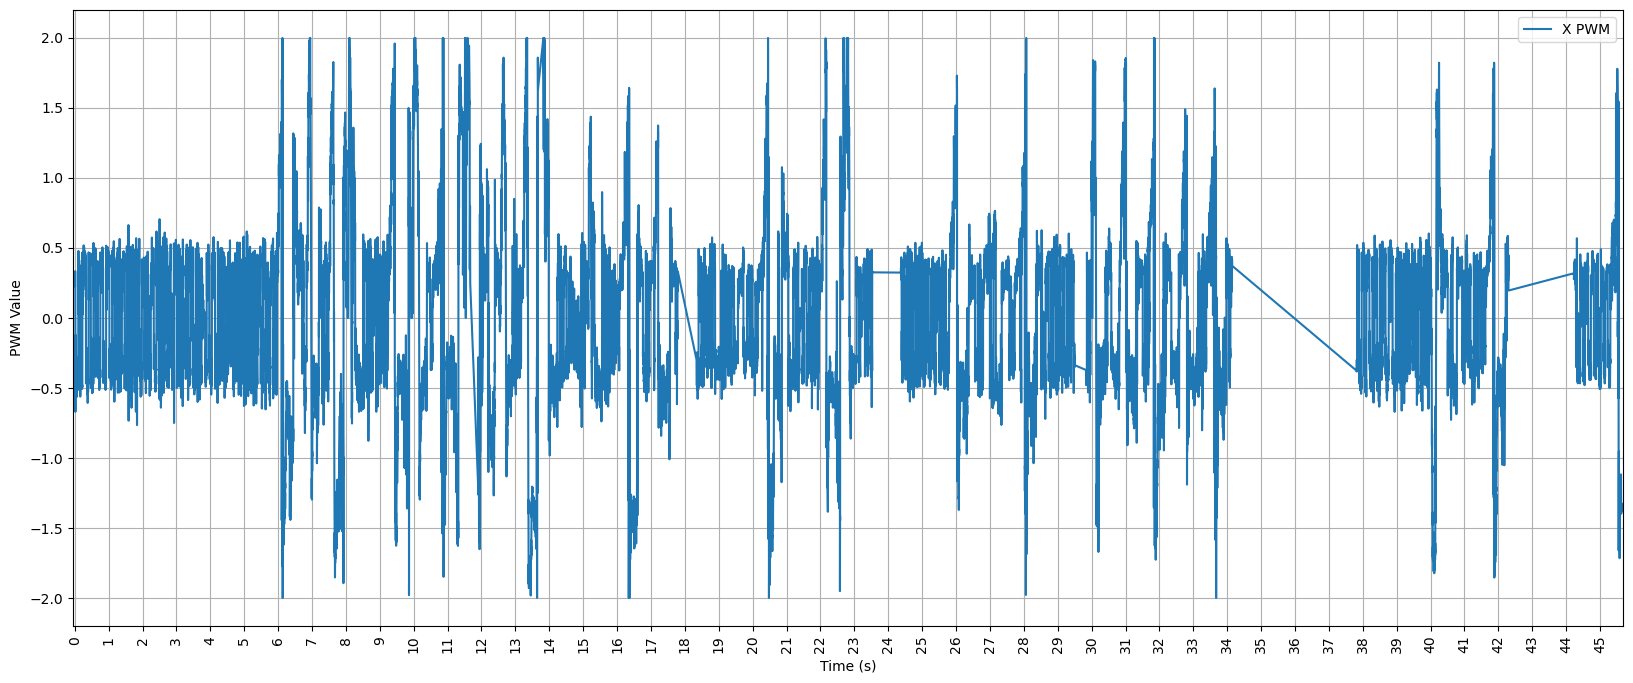

In [29]:
time = (np.cumsum(raw_file['dt'])/1000.0-raw_file['dt'][0]/1000.0)[0:len(raw_file)]
start_idx = np.where(time >= 0)[0][0]
end_idx = len(raw_file) -1#np.where(time >= 1)[0][0]#
sim_idxs = sim_file['index'].to_numpy()

# Vx_mask = np.ones_like(time, dtype=bool)
# Vx_mask[low_vx] = False

fig = plt.figure(figsize=(20, 8))
plt.plot(time[start_idx:end_idx], raw_file['x'][start_idx:end_idx], label='X Position')
plt.scatter(time[sim_idxs], sim_file['x'], s=1, color='orange', alpha=0.8, label='Simulated X Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.xticks(np.arange(time[start_idx], time[end_idx], 1), rotation=90)
plt.xlim(time[start_idx]-0.05, time[end_idx]+0.05)
plt.grid()
plt.legend()
plt.show()
fig2 = plt.figure(figsize=(20, 8))
plt.plot(time[sim_idxs], Vx[sim_idxs], label='X PWM')
plt.xlabel('Time (s)')
plt.ylabel('PWM Value')
plt.xticks(np.arange(time[start_idx], time[end_idx], 1), rotation=90)
plt.xlim(time[start_idx]-0.05, time[end_idx]+0.05)
plt.grid()
plt.legend()
plt.show()

In [ ]:
low_vy = sorted(list(find_low_pwm(Vy)))

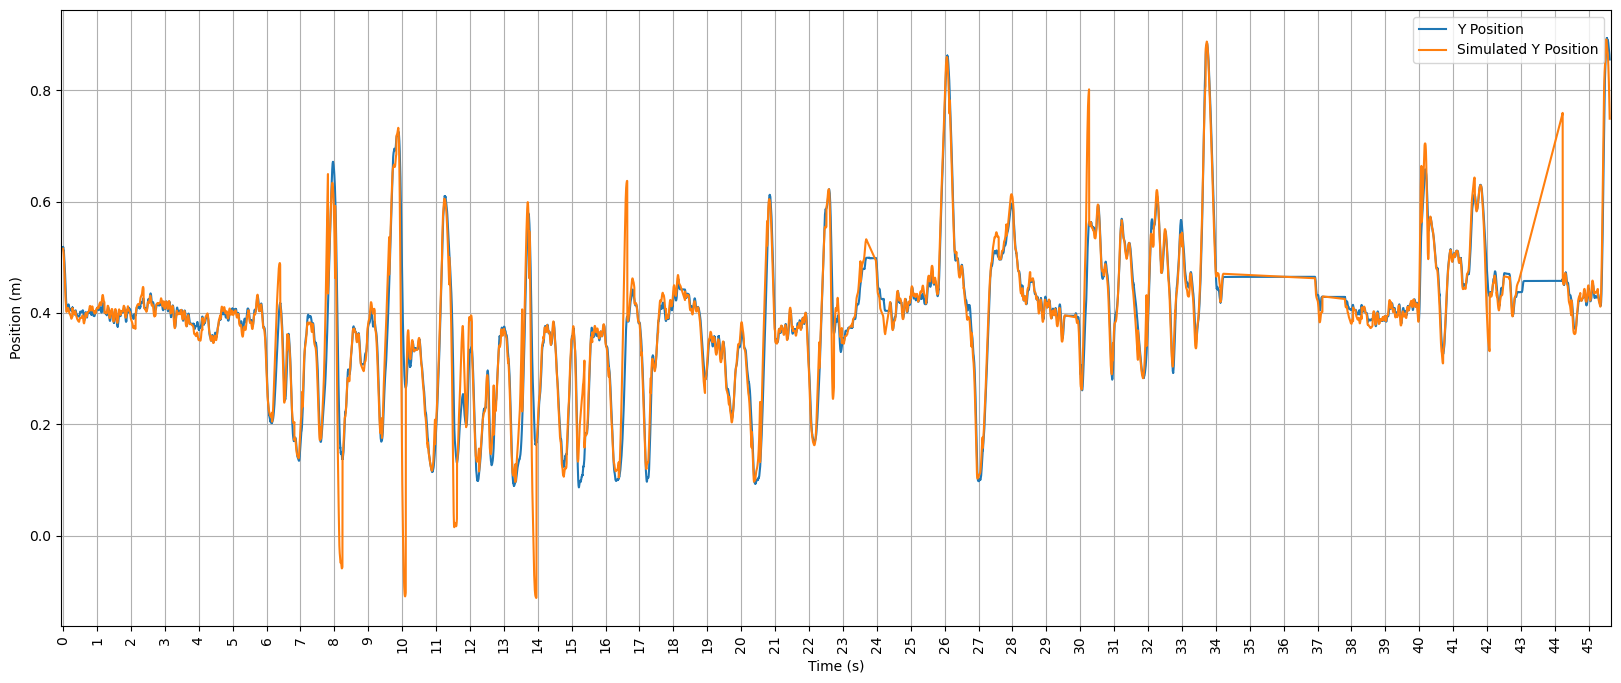

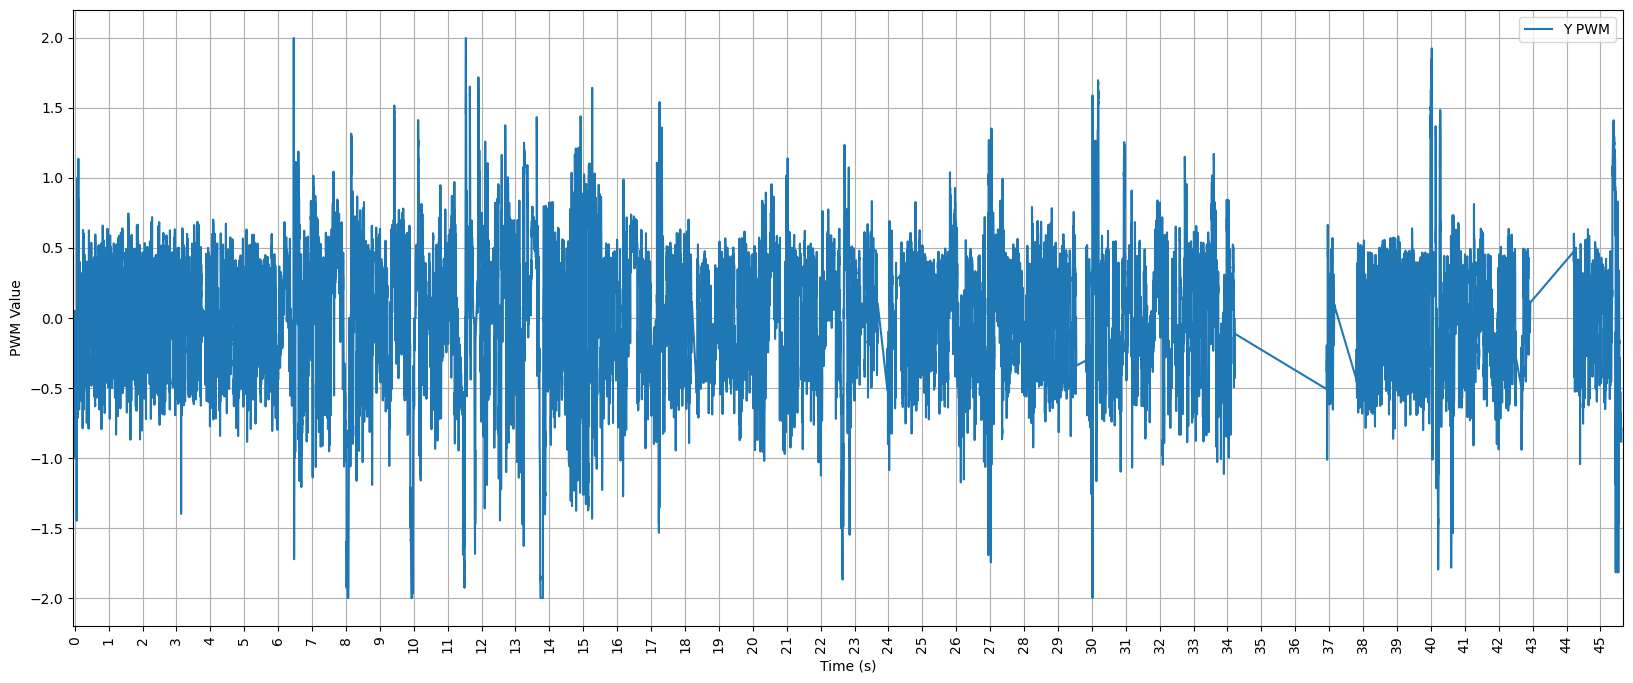

In [392]:
time = (np.cumsum(raw_file['dt'])/1000.0-raw_file['dt'][0]/1000.0)[0:len(sim_file)]
start_idx = np.where(time >= 0)[0][0]
end_idx = len(sim_file) -1#np.where(time >= 44.24)[0][0]#

Vy_mask = np.ones_like(time, dtype=bool)
Vy_mask[low_vy] = False

fig = plt.figure(figsize=(20, 8))
plt.plot(time[start_idx:end_idx], raw_file['y'][start_idx:end_idx], label='Y Position')
plt.plot(sim_file['time'][Vy_mask], sim_file['y'][Vy_mask], label='Simulated Y Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.xticks(np.arange(time[start_idx], time[end_idx], 1), rotation=90)
plt.xlim(time[start_idx]-0.05, time[end_idx]+0.05)
plt.grid()
plt.legend()
plt.show()
fig2 = plt.figure(figsize=(20, 8))
plt.plot(time[Vy_mask], Vy[0:len(sim_file)][Vy_mask], label='Y PWM')
plt.xlabel('Time (s)')
plt.ylabel('PWM Value')
plt.xticks(np.arange(time[start_idx], time[end_idx], 1), rotation=90)
plt.xlim(time[start_idx]-0.05, time[end_idx]+0.05)
plt.grid()
plt.legend()
plt.show()